# Prédiction (4/4)

L'objectif de ce notebook est de trouver le meilleur modèle de classification binaire possible de Machine Learning pour prédire la selection à la draft d'un joueur universitaire.  

Le dataset est composé d'environ 20 000 joueurs de la première division de la NCAA entre 2010-2019. 

Les labels à prédire sont : 
- 1 le joueur a été drafté
- 0 le joueur n'a pas été drafté

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
import seaborn as sns
SEED = 22

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ncaa_final.csv', index_col=0)
df.head()

,player_id,name,Season,assist_percentage,assists,block_percentage,blocks,box_plus_minus,conference,defensive_box_plus_minus,...,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,weight,win_shares,win_shares_per_40_minutes,drafted,Ranking
0,6903,Evan Washington,Career,19.2,2.637097,1.5,0.379032,1.300000,19,1.3000,...,2.032258,4.991935,0.477,2.379032,18.1,200.0,7.0,0.070,0,-100.0
1,14342,Michael Lyons,Career,15.3,1.860870,1.1,0.234783,2.400000,19,-1.2000,...,1.982609,6.547826,0.541,3.539130,26.7,193.0,9.0,0.103,0,-100.0
2,18829,Todd Fletcher,Career,22.5,2.951613,0.4,0.088710,1.200000,19,0.5000,...,1.387097,2.500000,0.555,1.387097,14.8,183.0,8.0,0.093,0,-100.0
3,1589,Avery Merriex,Career,12.4,0.657143,0.4,0.028571,-3.023823,19,-0.5633,...,0.600000,0.985714,0.420,0.414286,10.9,190.0,0.2,0.008,0,-100.0
4,17732,Shawn Hempsey,Career,19.5,0.795455,0.3,0.022727,-4.000000,19,0.7000,...,0.511364,0.659091,0.466,0.306818,12.4,180.0,0.2,0.010,0,-100.0


In [3]:
no_drafted, drafted = df["drafted"].value_counts()
print('Présence de joueurs non draftés :',round(no_drafted/df["drafted"].count(),2)*100,'%')
print('Présence de joueurs  draftés :', round(drafted/df["drafted"].count(),2)*100,'%')

Présence de joueurs non draftés : 98.0 %
Présence de joueurs  draftés : 2.0 %


## Regression Logistique 

In [4]:
X = df.drop(columns=["player_id","name","Season"])
y = df["drafted"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)


target_names = ['Not Drafted', 'Drafted']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

 Not Drafted       0.99      1.00      0.99      6635
     Drafted       0.72      0.55      0.63       147

    accuracy                           0.99      6782
   macro avg       0.86      0.77      0.81      6782
weighted avg       0.98      0.99      0.98      6782



high recall + high precision : the class is perfectly handled by the model  

low recall + high precision : the model can’t detect the class well but is highly trustable when it does  

high recall + low precision : the class is well detected but the model also include points of other classes in it  

low recall + low precision : the class is poorly handled by the model

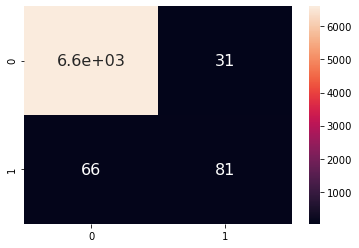

In [7]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred),annot=True, annot_kws={"size": 16});

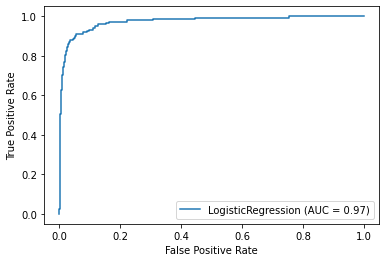

In [8]:
metrics.plot_roc_curve(log_reg, X_test, y_test)

### GridSearch 



In [9]:
lg_reg = LogisticRegression(fit_intercept=False, C=1e16, random_state=2)
lg_param_grid = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25,45]}
log_grid_search = GridSearchCV(lg_reg, lg_param_grid, cv=5, return_train_score=True)
print(log_grid_search.fit(X_train,y_train))

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1e+16, fit_intercept=False,
                                          random_state=2),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25, 45],
                         'penalty': ['l1', 'l2']},
             return_train_score=True)


In [10]:
log_gs_training_score = np.mean(log_grid_search.cv_results_['mean_train_score'])
log_gs_testing_score = log_grid_search.score(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = log_grid_search.predict(X_test)

# New Model Evaluation metrics 
print("Mean Training Score:", log_gs_training_score*100)
print("Mean Testing Score:", log_gs_testing_score*100)
print('Accuracy Score : ' + str(metrics.accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(metrics.precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(metrics.recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(metrics.f1_score(y_test,y_pred_acc)))
print("Best Parameter Found:")
log_grid_search.best_params_

Mean Training Score: nan
Mean Testing Score: 98.44555821892932
Accuracy Score : 0.9862872309053377
Precision Score : 0.7755102040816326
Recall Score : 0.5170068027210885
F1 Score : 0.620408163265306
Best Parameter Found:


{'C': 5, 'penalty': 'l2'}

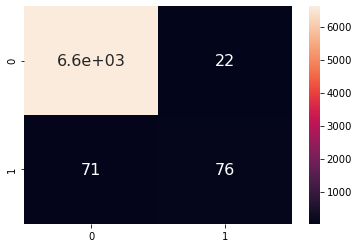

In [11]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_acc),annot=True, annot_kws={"size": 16});

### Random Under-Sampling  

Nous sommes en situation d' **Imbalanced Datasets**  
De ce fait, nous devons créer un *subsample** où nous avons 50% de joueurs draftés et 50% de joueurs non draftés

In [12]:
draft_df = df.loc[df['drafted'] == 1]
non_draft_df = df.loc[df['drafted'] == 0][:drafted]

df_sample = pd.concat([draft_df,non_draft_df]).sample(frac=1, random_state=42)
df_sample.head()

,player_id,name,Season,assist_percentage,assists,block_percentage,blocks,box_plus_minus,conference,defensive_box_plus_minus,...,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,weight,win_shares,win_shares_per_40_minutes,drafted,Ranking
15026,15122,Nerlens Noel,Career,9.5,1.583333,13.2,4.416667,12.1,24,7.8,...,1.875000,6.916667,0.590,4.083333,17.4,228.0,3.9,0.206000,1,1.0
16399,11206,Justin Jackson,Career,15.6,2.661017,1.3,0.381356,8.4,1,2.0,...,1.381356,7.161017,0.529,3.788136,23.3,193.0,9.7,0.082468,1,9.0
15156,18804,T.J. Warren,Career,7.4,0.971429,1.7,0.514286,9.6,1,1.7,...,1.671429,11.542857,0.598,6.900000,28.6,233.0,10.6,0.194000,1,27.0
301,10656,Jorge Gutierrez,Career,23.7,3.279070,0.5,0.116279,5.4,22,2.7,...,2.124031,5.496124,0.461,2.534884,21.8,195.0,10.6,0.124000,0,-100.0
12730,19641,Tyler Zeller,Career,4.9,0.589744,4.6,1.111111,10.2,1,3.7,...,1.410256,8.615385,0.544,4.683761,24.1,250.0,15.5,0.231000,1,-100.0


In [13]:
no_drafted, drafted = df_sample["drafted"].value_counts()
print('Présence de joueurs non draftés :',round(no_drafted/df_sample["drafted"].count(),2)*100,'%')
print('Présence de joueurs  draftés :', round(drafted/df_sample["drafted"].count(),2)*100,'%')

Présence de joueurs non draftés : 50.0 %
Présence de joueurs  draftés : 50.0 %


In [14]:
X = df_sample.drop(columns=["drafted","Season"])
y = df_sample["drafted"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classificiation

In [16]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForrest" : RandomForestClassifier()
}

In [17]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "has training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

ValueError: could not convert string to float: 'Stephen Cox'

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')


tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')